In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(3896, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3896)              7982904   
Total params: 31,570,616
Trainable params: 31,517,496
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group7_set_224/set_224/train/'
valid_data_dir = '../datasets/group7_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 140556 images belonging to 3896 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 35064 images belonging to 3896 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group7_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

3896
{0: '100054', 1: '100130', 2: '100178', 3: '100265', 4: '1003', 5: '100322', 6: '100599', 7: '100670', 8: '100693', 9: '100795', 10: '100852', 11: '100856', 12: '100879', 13: '100881', 14: '100890', 15: '100897', 16: '100919', 17: '101067', 18: '101073', 19: '101080', 20: '101150', 21: '101151', 22: '101174', 23: '101209', 24: '101221', 25: '101226', 26: '101292', 27: '101398', 28: '101425', 29: '101426', 30: '10148', 31: '1015', 32: '101522', 33: '101524', 34: '101527', 35: '101588', 36: '101603', 37: '101604', 38: '101669', 39: '101723', 40: '101794', 41: '101821', 42: '101827', 43: '101836', 44: '101873', 45: '101894', 46: '101981', 47: '10199', 48: '102033', 49: '102171', 50: '102183', 51: '1022', 52: '102223', 53: '102349', 54: '102379', 55: '102389', 56: '10241', 57: '102429', 58: '102462', 59: '10252', 60: '102524', 61: '102660', 62: '102770', 63: '102858', 64: '102888', 65: '102944', 66: '102947', 67: '103094', 68: '103098', 69: '103171', 70: '10322', 71: '10327', 72: '103

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group7'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [17]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 100,
    workers = 8,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2196/2196 [==============================] - ETA: 0s - loss: 7.2705 - acc: 0.0275
Epoch 00001: val_acc improved from -inf to 0.16853, saving model to checkpoints_group7/model-01-0.17.hdf5
2196/2196 [==============================] - 682s 310ms/step - loss: 7.2705 - acc: 0.0275 - val_loss: 5.1112 - val_acc: 0.1685
Epoch 2/100
2196/2196 [==============================] - ETA: 0s - loss: 4.7077 - acc: 0.2047
Epoch 00002: val_acc improved from 0.16853 to 0.27463, saving model to checkpoints_group7/model-02-0.27.hdf5
2196/2196 [==============================] - 689s 314ms/step - loss: 4.7077 - acc: 0.2047 - val_loss: 4.3596 - val_acc: 0.2746
Epoch 3/100
2196/2196 [==============================] - ETA: 0s - loss: 3.6498 - acc: 0.3335
Epoch 00003: val_acc improved from 0.27463 to 0.38563, saving model to checkpoints_group7/model-03-0.39.hdf5
2196/2196 [==============================] - 689s 314ms/step - l

Epoch 28/100
2196/2196 [==============================] - ETA: 0s - loss: 0.3605 - acc: 0.9008
Epoch 00028: val_acc did not improve from 0.59103
2196/2196 [==============================] - 684s 312ms/step - loss: 0.3605 - acc: 0.9008 - val_loss: 3.0683 - val_acc: 0.5885
Epoch 29/100
2196/2196 [==============================] - ETA: 0s - loss: 0.3432 - acc: 0.9062
Epoch 00029: val_acc did not improve from 0.59103
2196/2196 [==============================] - 683s 311ms/step - loss: 0.3432 - acc: 0.9062 - val_loss: 3.5400 - val_acc: 0.5681
Epoch 30/100
2196/2196 [==============================] - ETA: 0s - loss: 0.3268 - acc: 0.9093
Epoch 00030: val_acc did not improve from 0.59103
2196/2196 [==============================] - 684s 311ms/step - loss: 0.3268 - acc: 0.9093 - val_loss: 3.5152 - val_acc: 0.5750
Epoch 31/100
2196/2196 [==============================] - ETA: 0s - loss: 0.3145 - acc: 0.9129
Epoch 00031: val_acc did not improve from 0.59103
2196/2196 [============================

Epoch 58/100
2196/2196 [==============================] - ETA: 0s - loss: 0.1438 - acc: 0.9591
Epoch 00058: val_acc did not improve from 0.62494
2196/2196 [==============================] - 691s 315ms/step - loss: 0.1438 - acc: 0.9591 - val_loss: 3.5179 - val_acc: 0.6070
Epoch 59/100
2196/2196 [==============================] - ETA: 0s - loss: 0.1394 - acc: 0.9600
Epoch 00059: val_acc did not improve from 0.62494
2196/2196 [==============================] - 690s 314ms/step - loss: 0.1394 - acc: 0.9600 - val_loss: 3.6242 - val_acc: 0.6097
Epoch 60/100
2196/2196 [==============================] - ETA: 0s - loss: 0.1351 - acc: 0.9616
Epoch 00060: val_acc did not improve from 0.62494
2196/2196 [==============================] - 690s 314ms/step - loss: 0.1351 - acc: 0.9616 - val_loss: 4.2601 - val_acc: 0.5332
Epoch 61/100
2196/2196 [==============================] - ETA: 0s - loss: 0.1356 - acc: 0.9610
Epoch 00061: val_acc did not improve from 0.62494
2196/2196 [============================

2196/2196 [==============================] - ETA: 0s - loss: 0.0921 - acc: 0.9731
Epoch 00088: val_acc did not improve from 0.62494
2196/2196 [==============================] - 684s 312ms/step - loss: 0.0921 - acc: 0.9731 - val_loss: 3.8815 - val_acc: 0.6057
Epoch 89/100
2196/2196 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.9735
Epoch 00089: val_acc did not improve from 0.62494
2196/2196 [==============================] - 684s 311ms/step - loss: 0.0924 - acc: 0.9735 - val_loss: 4.2569 - val_acc: 0.5583
Epoch 90/100
2196/2196 [==============================] - ETA: 0s - loss: 0.0897 - acc: 0.9739
Epoch 00090: val_acc did not improve from 0.62494
2196/2196 [==============================] - 684s 311ms/step - loss: 0.0897 - acc: 0.9739 - val_loss: 4.2748 - val_acc: 0.5899
Epoch 91/100
2196/2196 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.9742
Epoch 00091: val_acc did not improve from 0.62494
2196/2196 [==============================] - 684s 31

<Figure size 432x288 with 0 Axes>

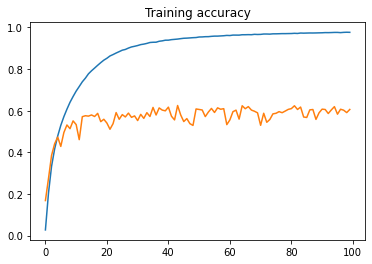

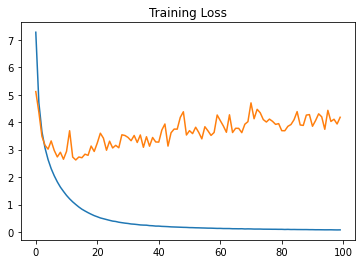

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg